# HW 16
## James Camacho

It's been a few homeworks, so let's remind everyone what the problem is. We're trying to solve

$$u_{xx}+u_{yy}+k^2u = f$$

where 

$$f = (k^2-1)(\cos x + \sin y).$$

We're given the exact solution

$$u(x, y) = j_0\left(k\sqrt{x^2+y^2}\right) + \cos(x) + \sin(y),$$

and that $j_0$ satisfies the homogenous equation.

### (a)
The nine-point Laplacian is

$$\nabla^2u = \frac{1}{3h^2}\left[\sum_{sym}U_{11} + \sum_{sym}U_{10} - 8U_{i,j}\right]$$

which comes from rotating the five-point stencil $45^\circ$ and adding it to itself. Our numerical method is

$$\frac{1}{3h^2}\left[\sum_{sym}U_{11} + \sum_{sym}U_{10} - 8U_{00}\right] + k^2U_{00} = F_{00}.$$

As it's symmetric, all odd powers will cancel out. Computing the even powers with the Taylor expansion, we have

$$\begin{align*}
[h^{-2}]\nabla^2u &=0\\
[h^0]\nabla^2u &= u_{xx}+u_{yy}\\
[h^2]\nabla^2u &= \frac{u_{xxxx}+4u_{xxyy}+u_{yyyy}}{12}
\end{align*}$$

so the local truncation error is

$$\tau = \frac{h^2}{12}(u_{xxxx}+4u_{xxyy}+u_{yyyy}) + O(h^4).$$

### (b)
From previous homework assignments know

$$\frac{h^2}{12}\left(u_{xxxx}+2u_{xxyy}+u_{yyyy}\right) = \frac{h^2}{12}\left(\nabla^2f - k^2(f-k^2u)\right),$$
$$\frac{h^2}{12}\left(2u_{xxyy}\right) = \frac{1}{6h^2}\left[\sum_{sym}U_{11} - 2\sum_{sym}U_{10} + 4U_{00}\right]$$

We rearrange this into two pieces, one correction for $f$, and the other for the finite difference matrix. We get the new method

$$\frac{2}{3}\sum_{sym}U_{10}+\frac{1}{6}\sum_{sym}U_{11}-\frac{10}{3}U_{00} + \left(h^2k^2-\frac{h^4k^4}{12}\right)U_{00} = h^2f + \frac{h^4}{12}(\nabla^2f-k^2f).$$

### (c)
This is implemented below:

In [94]:
import numpy as np
from scipy.special import jv
import scipy.sparse

j0 = lambda kr: jv(0, kr)

C00 = lambda h: -10/3 + h**2*k**2 - h**4*k**4/12
C10 = 2/3
C11 = 1/6

k = 20

def f(x, y):
    return (k**2 - 1)*(np.cos(x) + np.sin(y))

def laplace_f(x, y):
    return -f(x, y)

def u_exact(x, y):
    return j0(k*np.sqrt(x**2+y**2)) + np.cos(x) + np.sin(y)

def bdry(x, y, N):
    xi = np.linspace(0, 1, N)
    if x == None:
        return u_exact(xi, y)
    if y == None:
        return u_exact(x, xi)
    
    raise("Bad input. Example of good input: (None, 0) = along x axis with y=0.")

def add_boundaries(u, N):
    u = np.pad(u, pad_width=1, mode='empty').T
    u[0, :] = bdry(0, None, N)
    u[-1,:] = bdry(1, None, N)
    u[:, 0] = bdry(None, 0, N)
    u[:,-1] = bdry(None, 1, N)
    return u.T

def f_bdry(x, y, n):
    h = 1 / (n+1)
    xi = np.linspace(0, 1, n+2)
    if x == None:
        v = u_exact(xi, y)
    elif y == None:
        v = u_exact(x, xi)
    else:
        raise Exception("Bad input. Example of good input: (None, 0) = along x axis with y=0.")
    
    # So corners only get subtracted a total of once.
    v[0] /= 2
    v[-1] /= 2
    
    return v[1:-1]*C10 + (v[2:] + v[:-2])*C11

def get_F(n):
    h = 1 / (n+1)
    xi = np.linspace(0, 1, n+2)[1:-1]
    x, y = np.meshgrid(xi, xi)
    F = h**2 * f(x, y)
    F = F.reshape((n, n)).T
    
    # Subtract off Dirichlet boundaries
    F[0, :] -= f_bdry(0, None, n)
    F[-1, :] -= f_bdry(1, None, n)
    F[:, 0] -= f_bdry(None, 0, n)
    F[:, -1] -= f_bdry(None, 1, n)
    
    return F.T.flatten()

def get_A(n):
    h = 1 / (n+1)
    # Nine point stencil for Laplacian w/ error included
    d0 = np.full(n**2, C00(h))
    d1 = ([C10]*(n-1) + [0])*n # left/right
    d2 = np.full(n**2, C10) # up/down
    d3 = np.concatenate([[0]+[C11]*(n-1)]*n) # bl, tr corners
    d4 = np.concatenate([[C11]*(n-1)+[0]]*n) # tl, br corners
    diags = [d0, d1, d1, d2, d2, d3, d3, d4, d4]
    offsets = [0, 1, -1, n, -n, -n+1, n-1, -n-1, n+1]
    A = scipy.sparse.diags(diags, offsets)
    return A

def f_correction(n):
    h = 1 / (n+1)
    xi = np.linspace(0, 1, n+2)[1:-1]
    x, y = np.meshgrid(xi, xi)
    
    F = f(x, y).reshape((n, n))
    df = (-1-k**2)*F
    
    return df.flatten() * h**4 / 12

def solve_helmholtz(n, max_iters=1, error=1e-10):
    A = get_A(n)
    F = get_F(n) + f_correction(n)
    u = scipy.sparse.linalg.spsolve(A, F)
    
    return u

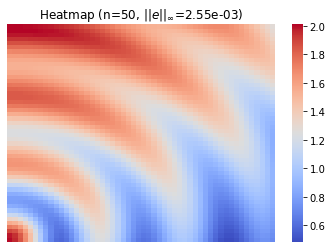

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

n = 50

u = solve_helmholtz(n)
u = u.reshape((n, n))
u = add_boundaries(u, n+2)

x = y = np.linspace(0, 1, n+2)
xx, yy = np.meshgrid(x, y)
ux = u_exact(xx, yy).reshape((n+2, n+2))
error = np.max(abs(u-ux))

plt.title(f"Heatmap (n={n}, "+r"$||e||_{\infty}$"+f"={error:.2e})")
ax = sns.heatmap(u, cmap="coolwarm")
ax.invert_yaxis()
plt.axis('off')
plt.show();

In [17]:
hs = []
errors = []
for n in [99, 199, 299, 399, 499]:
    n //= 10
    h = 1/(n+1)
    hs.append(h)
    u = solve_helmholtz(n)
    u = u.reshape((n, n))
    u = add_boundaries(u, n+2)

    x = y = np.linspace(0, 1, n+2)
    xx, yy = np.meshgrid(x, y)
    ux = u_exact(xx, yy).reshape((n+2, n+2))
    error = np.linalg.norm((u-ux).flatten(), ord=np.inf)
    
    errors.append(error)
    print(h, error)

0.1 5.224315513530087e-08
0.05 3.261604319959588e-09
0.03333333333333333 6.449192291313466e-10
0.025 2.0439872017163907e-10
0.02 8.393508110771108e-11


c:\python37\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


Slope: 3.997739613718492


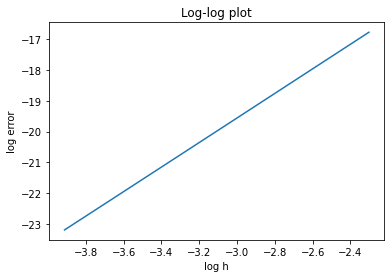

In [18]:
log_h = np.log(hs)
log_e = np.log(errors)
plt.plot(log_h, log_e)
plt.title("Log-log plot")
plt.xlabel("log h")
plt.ylabel("log error")

slope, _ = np.polyfit(log_h, log_e, deg=1)
print("Slope:", slope)

As you can see, it is fourth-order.